样本读取，整理

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

model_name = 'ResNet32_acc893.h5'
model = keras.models.load_model(model_name)

clean_images = np.load('../../pickles/cleanimages.npy')
attack_results = np.load('../../pickles/advimages.npy')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [2]:
perturbed_images = np.copy(clean_images)
for image in perturbed_images:
    # 0.005 here results in a eucilid distance of about 0.3
    image += np.random.normal(0, 0.005, (32,32,3))
    image = np.clip(image, 0., 1.)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

计算LID

In [4]:
from sklearn.metrics import roc_curve, auc
def roc_calc(pos,neg):
    pos = np.array(pos)
    neg = np.array(neg)
    label_pos = np.ones_like(pos)
    label_neg = np.zeros_like(neg)
    fpr, tpr, thresholds = roc_curve(np.concatenate([label_pos, label_neg]),
                                    np.concatenate([pos, neg]))
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

In [5]:
def l2_dist(x, y):
    return np.linalg.norm(x-y)

def LID(sample, batch):
    batch_copy = batch.copy()
    index = np.argwhere(batch_copy == sample)
    batch_copy = np.delete(batch_copy, index)
    dists = [l2_dist(sample, other_sample) for other_sample in batch_copy]
    dist_max = max(dists)
    lid = sum([np.log(dist/dist_max) for dist in dists])/float(len(dists))
    
    return -1.0/lid

In [6]:
from tensorflow.keras.models import Model
mini_batch_size = 16

sess = keras.backend.get_session()
layer_number = 0
for layer in model.layers[::-1]:
    # build model with input and output with each layer
    x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
    model_tmp = Model(inputs=model.input, outputs=layer.output)
    out = model_tmp(x)
    
    LID_layer_normal = []
    LID_layer_perturbed = []
    LID_layer_adv = []

    for i in range(len(clean_images)//mini_batch_size):
        print("layer:-%d i:%d" % (layer_number, i))
        start_i = i*mini_batch_size
        end_i = (i+1)*mini_batch_size
        normal_outs = out.eval(session=sess, feed_dict={x:clean_images[start_i:end_i]})
        perturbed_outs = out.eval(session=sess, feed_dict={x:perturbed_images[start_i:end_i]})
        adv_outs = [out.eval(session=sess, feed_dict={x:adv_images[start_i:end_i]}) for adv_images in attack_results]
        
        LID_batch_normal = [LID(normal_out, normal_outs) for normal_out in normal_outs]
        LID_batch_perturbed = [LID(perturbed_out, perturbed_outs) for perturbed_out in perturbed_outs]
        LID_batch_adv = [[LID(attack_out, attack_outs) for attack_out in attack_outs] for attack_outs in adv_outs]
        
        LID_layer_normal.extend(LID_batch_normal)
        LID_layer_perturbed.extend(LID_batch_perturbed)
        if not LID_layer_adv:
            LID_layer_adv = LID_batch_adv
        else:
            for layer_out,batch_out in zip(LID_layer_adv, LID_batch_adv):
                layer_out.extend(batch_out)
    
    LID_layer_normal.extend(LID_layer_perturbed)
    LID_pos = LID_layer_normal
    for LID_neg in LID_layer_adv:
        print(1-roc_calc(LID_pos, LID_neg))
    layer_number += 1

layer:-0 i:0
layer:-0 i:1
layer:-0 i:2
layer:-0 i:3
layer:-0 i:4
layer:-0 i:5
layer:-0 i:6
layer:-0 i:7
layer:-0 i:8
layer:-0 i:9
layer:-0 i:10
layer:-0 i:11
layer:-0 i:12
layer:-0 i:13
layer:-0 i:14
layer:-0 i:15
layer:-0 i:16
layer:-0 i:17
layer:-0 i:18
layer:-0 i:19
layer:-0 i:20
layer:-0 i:21
layer:-0 i:22
layer:-0 i:23
layer:-0 i:24
layer:-0 i:25
layer:-0 i:26
layer:-0 i:27
layer:-0 i:28
layer:-0 i:29
layer:-0 i:30
layer:-0 i:31
layer:-0 i:32
layer:-0 i:33
layer:-0 i:34
layer:-0 i:35
layer:-0 i:36
layer:-0 i:37
layer:-0 i:38
layer:-0 i:39
layer:-0 i:40
layer:-0 i:41
layer:-0 i:42
layer:-0 i:43
layer:-0 i:44
layer:-0 i:45
layer:-0 i:46
layer:-0 i:47
layer:-0 i:48
layer:-0 i:49
layer:-0 i:50
layer:-0 i:51
layer:-0 i:52
layer:-0 i:53
layer:-0 i:54
layer:-0 i:55
layer:-0 i:56
layer:-0 i:57
layer:-0 i:58
layer:-0 i:59
layer:-0 i:60
layer:-0 i:61
layer:-0 i:62
layer:-0 i:63
0.7380833625793457
0.8974385261535645
0.9755964279174805
0.6237688064575195
0.8775897026062012
layer:-1 i:0
layer:

KeyboardInterrupt: 

绘制ROC

In [30]:
LID_pos = LID_layer_normal
for LID_neg in LID_layer_adv:
        print(roc_calc(LID_pos, LID_neg))

ValueError: unknown format is not supported

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


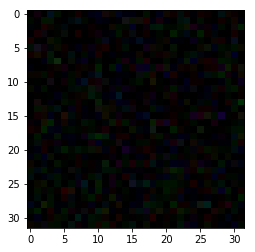

In [12]:
plt.imshow(10*(perturbed_images[3] - clean_images[3]))

In [43]:
z = np.array(LID_layer_adv)
z.shape

(5, 48)